## Import the necessary packages

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout, BatchNormalization,Bidirectional,GRU
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
from sklearn.model_selection import RandomizedSearchCV


## read the dataset

In [73]:
df = pd.read_csv('synthetic_cognitive_strain_data.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9863 entries, 0 to 9862
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Task_ID            9863 non-null   int64  
 1   Developer_ID       9863 non-null   int64  
 2   Task_Complexity    9863 non-null   object 
 3   Work_Hours         9863 non-null   int64  
 4   Task_Duration      9863 non-null   float64
 5   Errors             9863 non-null   int64  
 6   Stress_Level       9863 non-null   object 
 7   Heart_Rate         9863 non-null   int64  
 8   Sleep_Quality      9863 non-null   object 
 9   Multitasking       9863 non-null   object 
 10  Deadline_Pressure  9863 non-null   object 
 11  Cognitive_Strain   9863 non-null   int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 924.8+ KB


In [74]:
df.head()

,Task_ID,Developer_ID,Task_Complexity,Work_Hours,Task_Duration,Errors,Stress_Level,Heart_Rate,Sleep_Quality,Multitasking,Deadline_Pressure,Cognitive_Strain
0,1,151,Medium,5,3.066465,3,Medium,63,Average,Yes,High,125
1,2,192,Medium,9,3.768117,2,Medium,83,Average,Yes,High,135
2,3,114,High,11,1.713952,0,Low,78,Poor,No,Low,125
3,4,171,Low,4,3.653080,4,High,89,Good,Yes,Low,130
4,5,160,Medium,9,1.638334,3,Medium,81,Good,No,Low,145


In [75]:
df.columns

Index(['Task_ID', 'Developer_ID', 'Task_Complexity', 'Work_Hours',
       'Task_Duration', 'Errors', 'Stress_Level', 'Heart_Rate',
       'Sleep_Quality', 'Multitasking', 'Deadline_Pressure',
       'Cognitive_Strain'],
      dtype='object')

**Drop the columns Task_ID, Developer_ID** 

In [76]:
df = df.drop(columns = ['Task_ID','Developer_ID'])
df

,Task_Complexity,Work_Hours,Task_Duration,Errors,Stress_Level,Heart_Rate,Sleep_Quality,Multitasking,Deadline_Pressure,Cognitive_Strain
0,Medium,5,3.066465,3,Medium,63,Average,Yes,High,125
1,Medium,9,3.768117,2,Medium,83,Average,Yes,High,135
2,High,11,1.713952,0,Low,78,Poor,No,Low,125
3,Low,4,3.653080,4,High,89,Good,Yes,Low,130
4,Medium,9,1.638334,3,Medium,81,Good,No,Low,145
...,...,...,...,...,...,...,...,...,...,...
9858,High,9,3.833826,2,Low,85,Average,Yes,High,135
9859,High,8,2.275120,3,Medium,97,Good,Yes,Low,160
9860,Medium,4,2.072942,3,High,62,Good,No,Medium,140
9861,Medium,5,1.366409,1,Low,96,Poor,No,Medium,85


**Data type info**

In [77]:
## data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9863 entries, 0 to 9862
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Task_Complexity    9863 non-null   object 
 1   Work_Hours         9863 non-null   int64  
 2   Task_Duration      9863 non-null   float64
 3   Errors             9863 non-null   int64  
 4   Stress_Level       9863 non-null   object 
 5   Heart_Rate         9863 non-null   int64  
 6   Sleep_Quality      9863 non-null   object 
 7   Multitasking       9863 non-null   object 
 8   Deadline_Pressure  9863 non-null   object 
 9   Cognitive_Strain   9863 non-null   int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 770.7+ KB


## Univariate Analysis

**Categorical columns analysis**

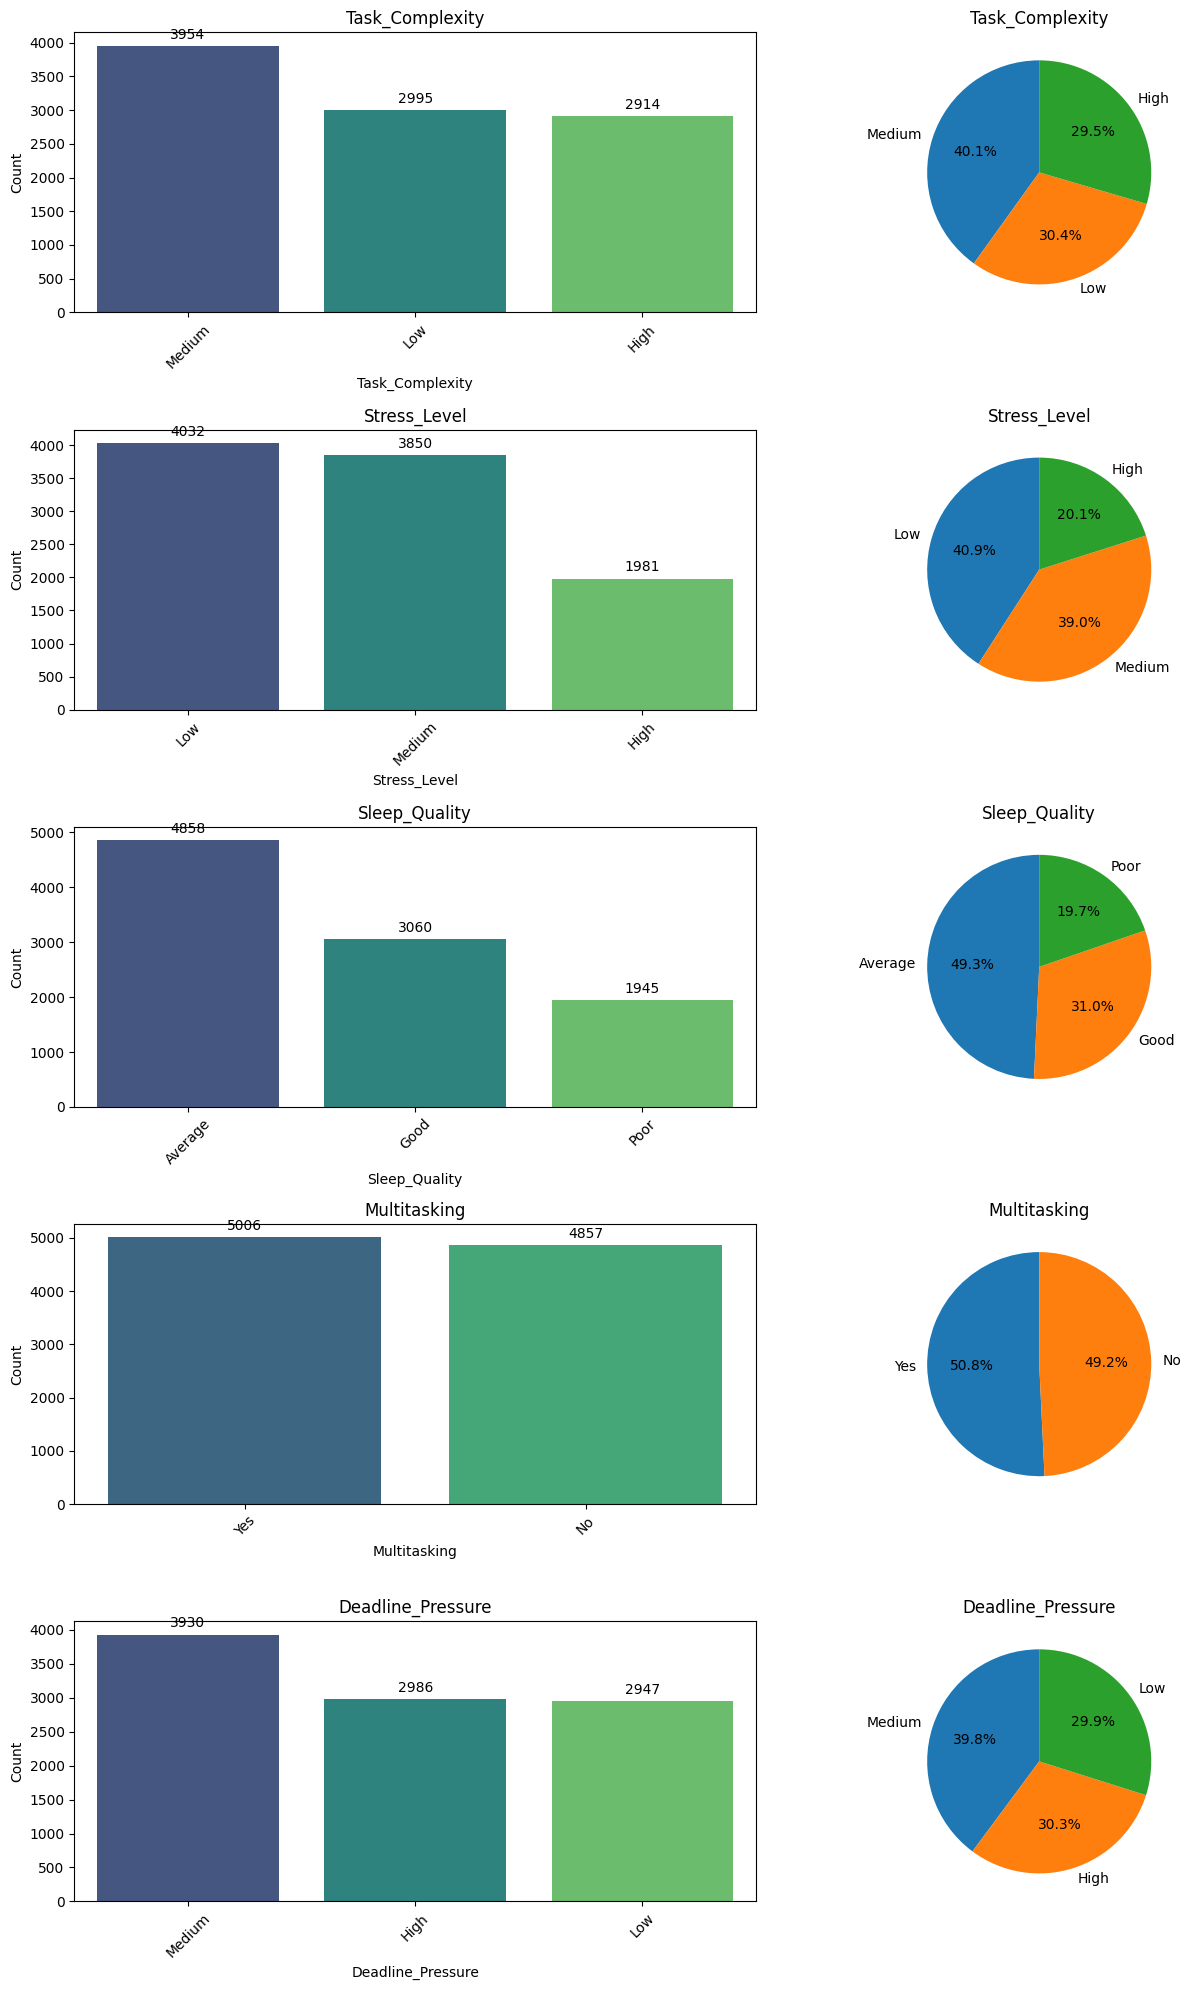

In [78]:
def univariate_categorical_analysis(df):
    # Define the columns to analyze
    columns = df.select_dtypes(include='object').columns.tolist()
    
    # Set up the figure and axes for subplots
    num_columns = len(columns)
    fig, axes = plt.subplots(num_columns, 2, figsize=(14, 4 * num_columns))
    
    # Loop through each column and create bar plots and pie charts
    for i, column in enumerate(columns):
        # Calculate the frequency distribution
        freq_dist = df[column].value_counts()
        
        # Bar plot
        bar_plot = sns.barplot(x=freq_dist.index, y=freq_dist.values, ax=axes[i, 0], palette='viridis')
        axes[i, 0].set_title(f'{column}')
        axes[i, 0].set_xlabel(column)
        axes[i, 0].set_ylabel('Count')
        axes[i, 0].tick_params(axis='x', rotation=45)  # Rotate x labels if needed
        
        # Remove the bar borders (lines)
        for bar in bar_plot.patches:
            bar.set_edgecolor('none')  # Remove the border color
            bar.set_linewidth(0)       # Set border width to 0
        
        # Add counts on top of bars
        for p in bar_plot.patches:
            height = p.get_height()  # Get the height of the bar
            bar_plot.annotate(f'{int(height)}', 
                              (p.get_x() + p.get_width() / 2., height), 
                              xytext=(0, 3), 
                              textcoords='offset points', 
                              ha='center', 
                              va='bottom')
        
        # Pie chart
        axes[i, 1].pie(freq_dist, labels=freq_dist.index, autopct='%1.1f%%', startangle=90)
        axes[i, 1].set_title(f'{column}')
    plt.savefig("figure.png")
    
    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()

univariate_categorical_analysis(df)

**Numerical columnns analysis**

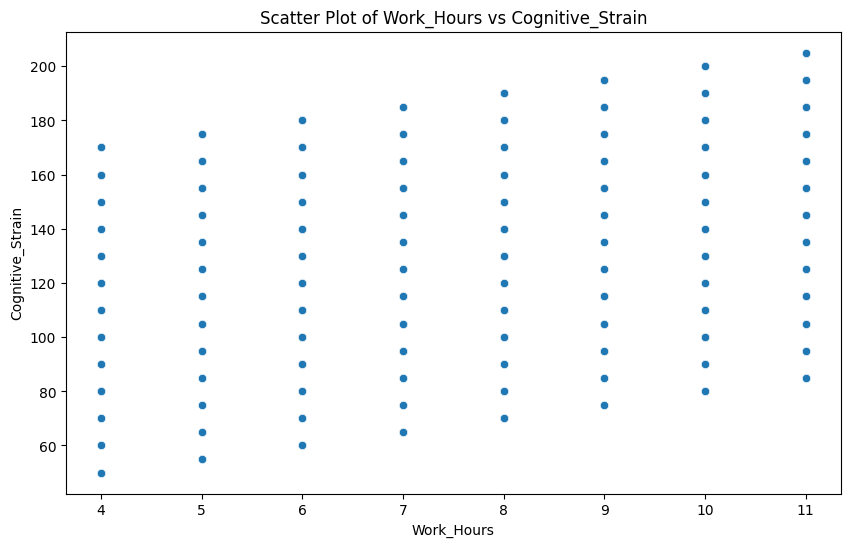

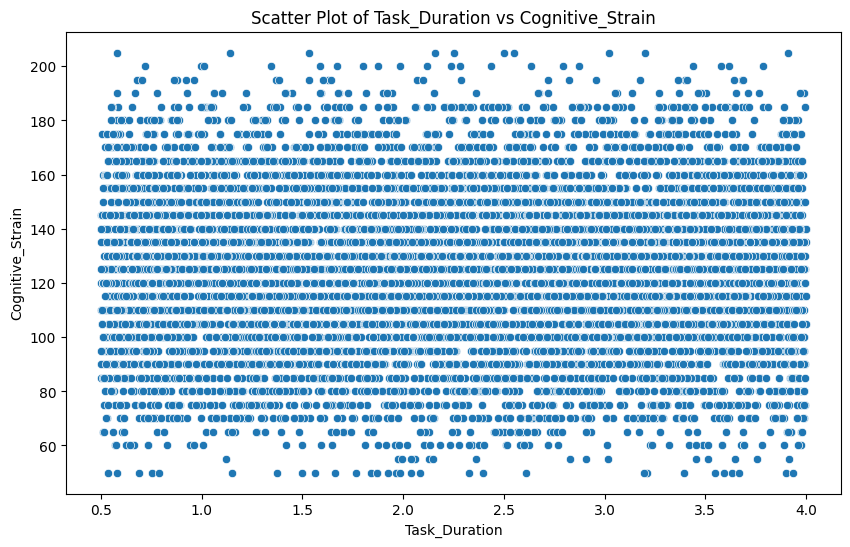

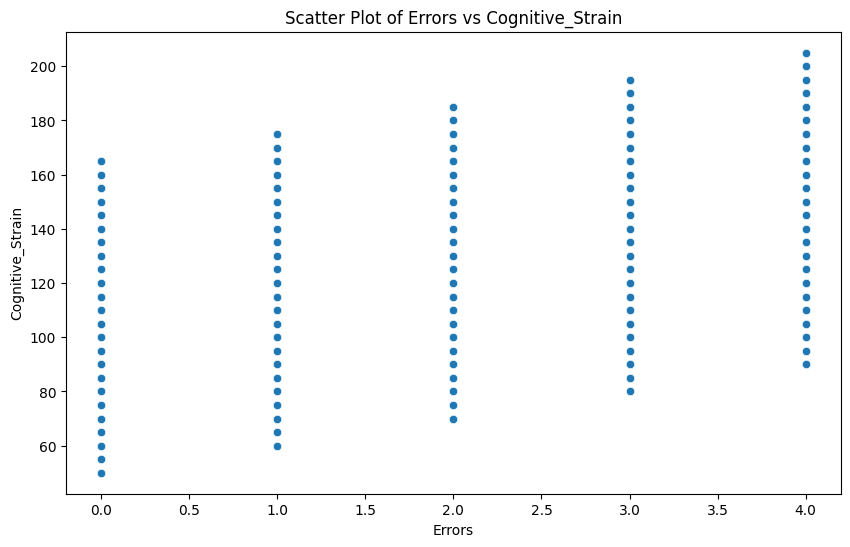

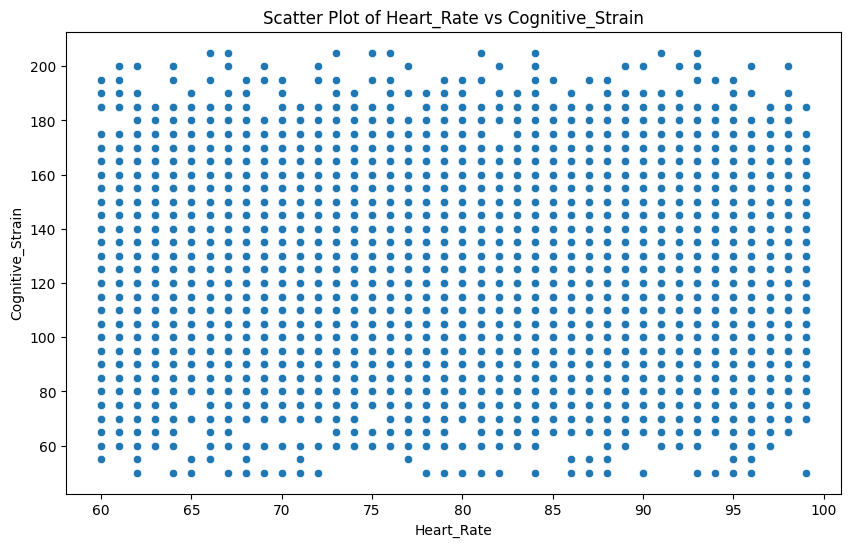

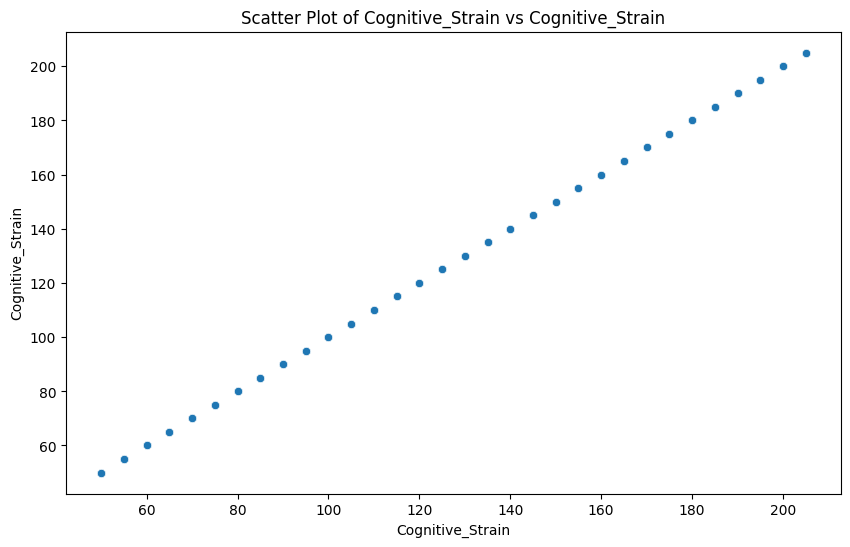

In [79]:
num_col = df.select_dtypes(exclude = 'object').columns.tolist()

for col in num_col:
    plt.figure(figsize=(10,6))
    sns.scatterplot(x= df[col], y=df['Cognitive_Strain'])
    plt.title(f'Scatter Plot of {col} vs Cognitive_Strain')
    plt.xlabel(col)
    plt.ylabel('Cognitive_Strain')
    plt.show()

## Bivariate Analysis

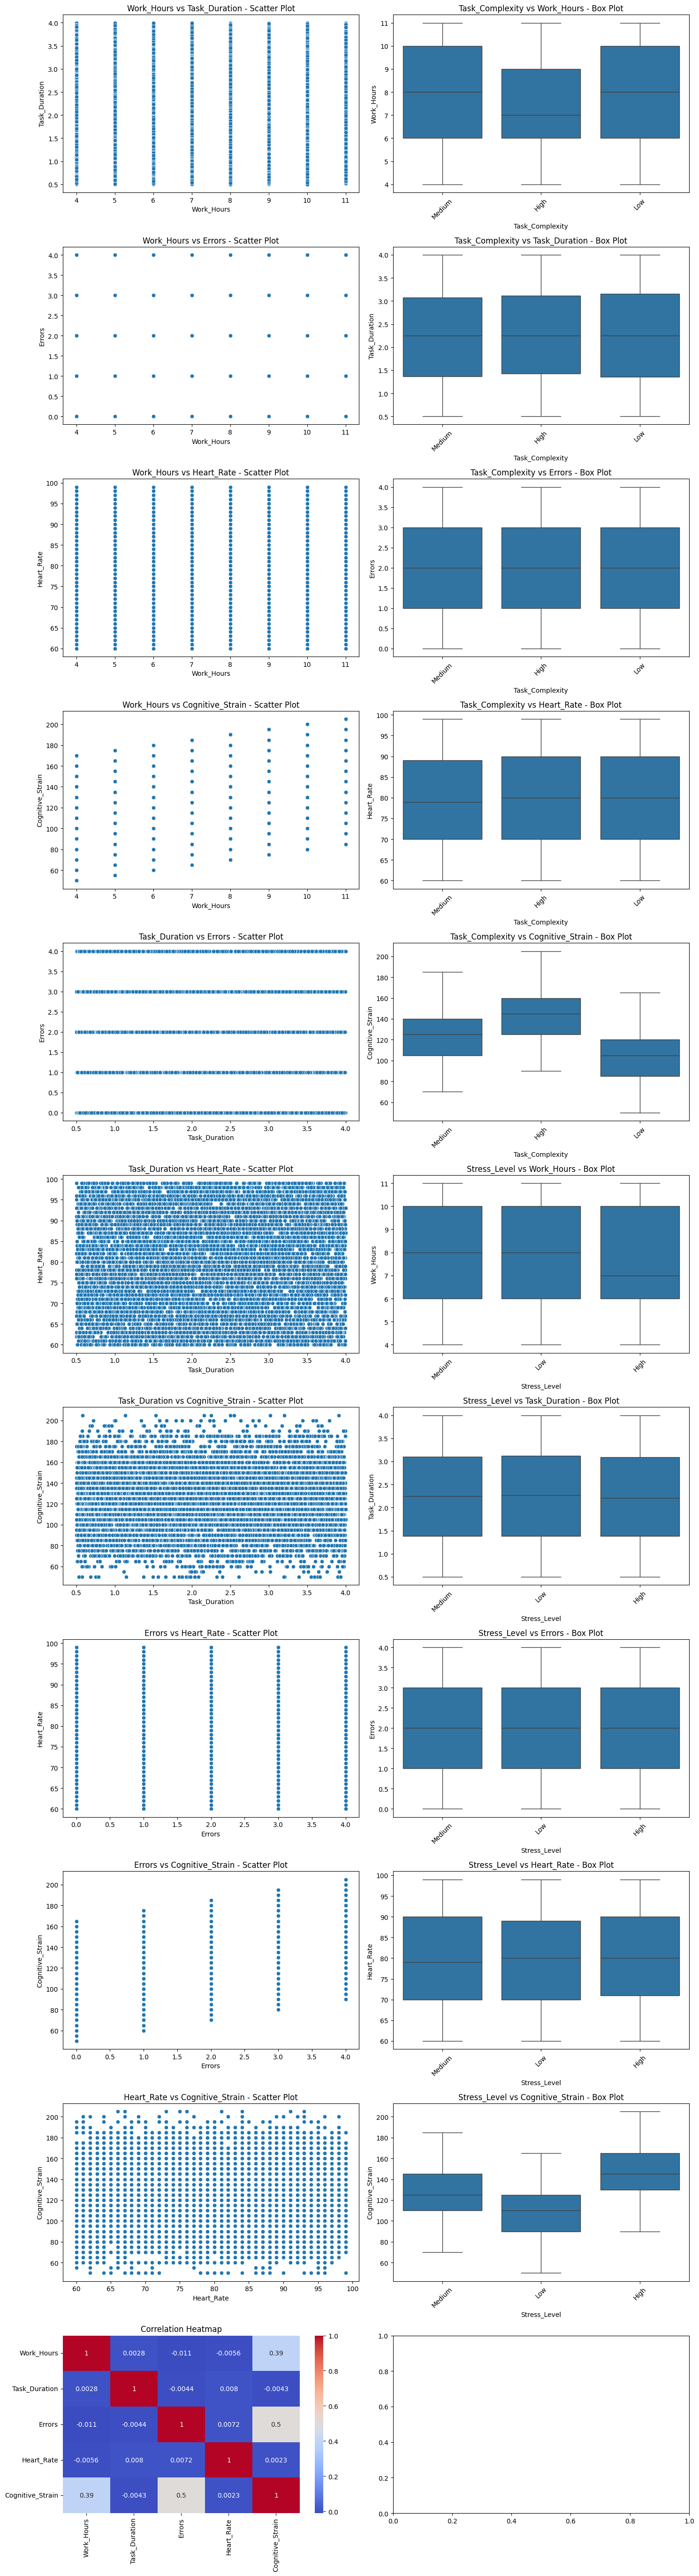

In [80]:
def bivariate_analysis(df):
    # Define columns
    numerical_cols = df.select_dtypes(exclude= 'object').columns.tolist()
    categorical_cols = df.select_dtypes(include= 'object').columns.tolist()
    
    # Plot numerical vs. numerical relationships
    num_pairs = [(x, y) for i, x in enumerate(numerical_cols) for y in numerical_cols[i+1:]]
    
    # Scatter plots and correlation heatmap for numerical variables
    num_plots = len(num_pairs)
    fig, axes = plt.subplots(num_plots + 1, 2, figsize=(15, 5 * (num_plots + 1)))
    
    # Scatter Plots
    for i, (x, y) in enumerate(num_pairs):
        sns.scatterplot(data=df, x=x, y=y, ax=axes[i, 0])
        axes[i, 0].set_title(f'{x} vs {y} - Scatter Plot')
    
    # Correlation Heatmap
    corr_matrix = df[numerical_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=axes[num_plots, 0])
    axes[num_plots, 0].set_title('Correlation Heatmap')
    
    # Plot categorical vs. numerical relationships
    cat_pairs = [(x, y) for x in categorical_cols for y in numerical_cols]
    
    # Box plots for categorical vs. numerical
    for i, (cat, num) in enumerate(cat_pairs):
        if i >= num_plots:
            break
        sns.boxplot(data=df, x=cat, y=num, ax=axes[i, 1])
        axes[i, 1].set_title(f'{cat} vs {num} - Box Plot')
        axes[i, 1].tick_params(axis='x', rotation=45)  # Rotate x labels if needed
    
    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()

bivariate_analysis(df)

## Data Transformation and Data Scaling

In [81]:
## data scaling

def encode_categorical_columns(df, categorical_columns):
    df_encoded = df.copy()

    label_encoders = {}
    for column in categorical_columns:
        # Check if the column exists in the DataFrame
        if column in df_encoded.columns:
            le = LabelEncoder()
            df_encoded[column] = le.fit_transform(df_encoded[column])
            label_encoders[column] = le
        else:
            raise ValueError(f"Column {column} is not in the DataFrame")
    
    return df_encoded, label_encoders


categorical_cols = df.select_dtypes(include= 'object').columns.tolist()
df_encoded, encoders = encode_categorical_columns(df, categorical_cols)
df = df_encoded

In [82]:
df.corr()

,Task_Complexity,Work_Hours,Task_Duration,Errors,Stress_Level,Heart_Rate,Sleep_Quality,Multitasking,Deadline_Pressure,Cognitive_Strain
Task_Complexity,1.000000,0.015569,-0.009252,-0.001404,0.000152,-0.014376,0.027008,-0.001925,-0.002288,-0.246342
Work_Hours,0.015569,1.000000,0.002781,-0.010690,0.005512,-0.005602,0.004752,-0.020084,-0.017008,0.388294
Task_Duration,-0.009252,0.002781,1.000000,-0.004393,0.006038,0.008000,-0.011080,-0.002065,-0.001313,-0.004287
Errors,-0.001404,-0.010690,-0.004393,1.000000,-0.012100,0.007161,0.009043,-0.007784,-0.000287,0.504585
Stress_Level,0.000152,0.005512,0.006038,-0.012100,1.000000,-0.009545,-0.012445,-0.009421,0.000019,-0.168117
Heart_Rate,-0.014376,-0.005602,0.008000,0.007161,-0.009545,1.000000,-0.003137,-0.013237,0.000248,0.002254
Sleep_Quality,0.027008,0.004752,-0.011080,0.009043,-0.012445,-0.003137,1.000000,-0.010842,0.019282,0.011251
Multitasking,-0.001925,-0.020084,-0.002065,-0.007784,-0.009421,-0.013237,-0.010842,1.000000,0.011426,-0.006259
Deadline_Pressure,-0.002288,-0.017008,-0.001313,-0.000287,0.000019,0.000248,0.019282,0.011426,1.000000,-0.007208
Cognitive_Strain,-0.246342,0.388294,-0.004287,0.504585,-0.168117,0.002254,0.011251,-0.006259,-0.007208,1.000000


<Axes: >

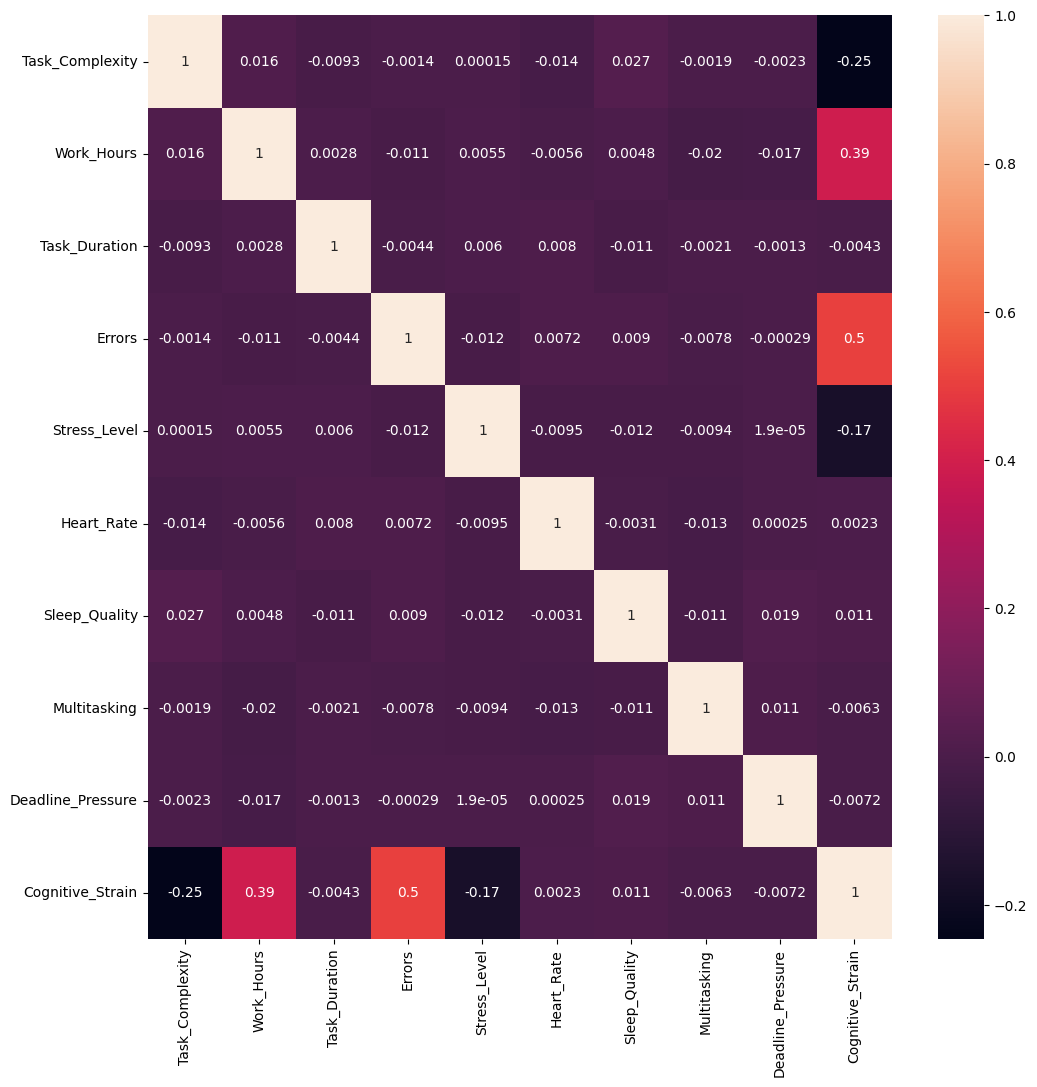

In [83]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), annot=True)

In [84]:
## data transformation

X = df.drop('Stress_Level', axis=1)
y = df['Stress_Level']

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert normalized features to DataFrame for easier manipulation
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Define features and target variable after scaling
X = df[['Task_Complexity', 'Work_Hours', 'Task_Duration', 'Errors',
        'Heart_Rate', 'Sleep_Quality', 'Deadline_Pressure',
       'Cognitive_Strain']]
y = df['Stress_Level']

# Reshape the data for LSTM [samples, time steps, features]
# X = X.values.reshape((X.shape[0], 1, X.shape[1]))

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [85]:
from sklearn.feature_selection import VarianceThreshold
import numpy as np
import pandas as pd

# Example dataset with numerical features
data = df

# Convert DataFrame to NumPy array
X = data.values

# Set variance threshold (e.g., 0.1)
selector = VarianceThreshold(threshold=0.5)

# Fit and transform the data
X_reduced = selector.fit_transform(X)

# Get the mask of selected features
selected_features = selector.get_support(indices=True)

# Print the features that are retained
print("Retained features:", data.columns[selected_features])


Retained features: Index(['Task_Complexity', 'Work_Hours', 'Task_Duration', 'Errors',
       'Stress_Level', 'Heart_Rate', 'Sleep_Quality', 'Deadline_Pressure',
       'Cognitive_Strain'],
      dtype='object')


## Build the Model LSTM

In [86]:
df.columns.tolist()

['Task_Complexity',
 'Work_Hours',
 'Task_Duration',
 'Errors',
 'Stress_Level',
 'Heart_Rate',
 'Sleep_Quality',
 'Multitasking',
 'Deadline_Pressure',
 'Cognitive_Strain']

In [93]:
import pandas as pd
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import tensorflow as tf
# Function to evaluate any model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """Train and evaluate the model on training and test data."""
    model.fit(X_train, y_train)  # Train the model
    
    # Predict on the test data
    predictions = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')
    cm = confusion_matrix(y_test, predictions)
    
    return accuracy, precision, recall, f1, cm

# Models to evaluate
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'LR': LogisticRegression()
}

# Dictionary to store performance
model_performance = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'Confusion Matrix': []
}

# Loop through each model and evaluate
for model_name, model in models.items():
    accuracy, precision, recall, f1, cm = evaluate_model(model, X_train, y_train, X_test, y_test)
    model_performance['Model'].append(model_name)
    model_performance['Accuracy'].append(accuracy)
    model_performance['Precision'].append(precision)
    model_performance['Recall'].append(recall)
    model_performance['F1 Score'].append(f1)
    model_performance['Confusion Matrix'].append(cm)

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, input_shape=input_shape, return_sequences=True,  kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))  # 3 classes for Stress Level
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Convert DataFrame to NumPy array before reshaping
X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Build and train the LSTM model
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
lstm_model = create_lstm_model(input_shape)
lstm_model.fit(X_train_lstm, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Evaluate LSTM on test data
lstm_predictions = np.argmax(lstm_model.predict(X_test_lstm), axis=-1)
lstm_accuracy = accuracy_score(y_test, lstm_predictions)
lstm_precision = precision_score(y_test, lstm_predictions, average='weighted')
lstm_recall = recall_score(y_test, lstm_predictions, average='weighted')
lstm_f1 = f1_score(y_test, lstm_predictions, average='weighted')
lstm_cm = confusion_matrix(y_test, lstm_predictions)

# Append LSTM results to model performance
model_performance['Model'].append('LSTM')
model_performance['Accuracy'].append(lstm_accuracy)
model_performance['Precision'].append(lstm_precision)
model_performance['Recall'].append(lstm_recall)
model_performance['F1 Score'].append(lstm_f1)
model_performance['Confusion Matrix'].append(lstm_cm)

# Convert model performance dictionary to a DataFrame
model_performance_df = pd.DataFrame(model_performance)

# Print performance summary
print("\nModel Performance Summary:")
model_performance_df

Epoch 1/30
198/198 [==============================] - 14s 39ms/step - loss: 1.0194 - accuracy: 0.4916 - val_loss: 0.9124 - val_accuracy: 0.5494
Epoch 2/30
198/198 [==============================] - 4s 19ms/step - loss: 0.9139 - accuracy: 0.5385 - val_loss: 0.8250 - val_accuracy: 0.6128
Epoch 3/30
198/198 [==============================] - 4s 21ms/step - loss: 0.8440 - accuracy: 0.5925 - val_loss: 0.7657 - val_accuracy: 0.7129
Epoch 4/30
198/198 [==============================] - 4s 21ms/step - loss: 0.8091 - accuracy: 0.6221 - val_loss: 0.7615 - val_accuracy: 0.5792
Epoch 5/30
198/198 [==============================] - 4s 21ms/step - loss: 0.8113 - accuracy: 0.6145 - val_loss: 0.7536 - val_accuracy: 0.6172
Epoch 6/30
198/198 [==============================] - 4s 21ms/step - loss: 0.7826 - accuracy: 0.6410 - val_loss: 0.7346 - val_accuracy: 0.6996
Epoch 7/30
198/198 [==============================] - 4s 20ms/step - loss: 0.7780 - accuracy: 0.6537 - val_loss: 0.7325 - val_accuracy: 0.755

,Model,Accuracy,Precision,Recall,F1 Score,Confusion Matrix
0,Decision Tree,1.000000,1.000000,1.000000,1.000000,"[[400, 0, 0], [0, 829, 0], [0, 0, 744]]"
1,Random Forest,0.991384,0.991498,0.991384,0.991362,"[[387, 1, 12], [0, 827, 2], [0, 2, 742]]"
2,XGBoost,1.000000,1.000000,1.000000,1.000000,"[[400, 0, 0], [0, 829, 0], [0, 0, 744]]"
3,KNN,0.625443,0.621656,0.625443,0.622707,"[[191, 45, 164], [38, 623, 168], [115, 209, 420]]"
4,LR,0.616320,0.625821,0.616320,0.618479,"[[212, 18, 170], [3, 574, 252], [103, 211, 430]]"
5,LSTM,0.808414,0.822984,0.808414,0.803274,"[[267, 3, 130], [0, 813, 16], [1, 228, 515]]"


In [ ]:
from sklearn.ensemble import VotingClassifier

# Example with VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

clf1 = LogisticRegression()
clf2 = RandomForestClassifier()
clf3 = SVC(probability=True)

ensemble = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('svc', clf3)], voting='soft')
ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()),
                             ('svc', SVC(probability=True))],
                 voting='soft')

In [ ]:
y_pred = ensemble.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Confusion:",conf_matrix)

Accuracy: 0.85
Confusion: [[275   1 124]
 [  0 803  31]
 [  9 142 615]]
